In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine, text
from sklearn.model_selection import cross_val_score


%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format
warnings.filterwarnings('ignore')

### Load Houseprice Data from Thinkfuls DataBase

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

houseprices_df = pd.DataFrame(engine.connect().execute(text('select * from houseprices')))

# No need for an open connection,
# because you're only doing a single query
engine.dispose()

In [3]:
houseprices_df.info()
houseprices_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1460 non-null   int64  
 1   mssubclass     1460 non-null   int64  
 2   mszoning       1460 non-null   object 
 3   lotfrontage    1201 non-null   float64
 4   lotarea        1460 non-null   int64  
 5   street         1460 non-null   object 
 6   alley          91 non-null     object 
 7   lotshape       1460 non-null   object 
 8   landcontour    1460 non-null   object 
 9   utilities      1460 non-null   object 
 10  lotconfig      1460 non-null   object 
 11  landslope      1460 non-null   object 
 12  neighborhood   1460 non-null   object 
 13  condition1     1460 non-null   object 
 14  condition2     1460 non-null   object 
 15  bldgtype       1460 non-null   object 
 16  housestyle     1460 non-null   object 
 17  overallqual    1460 non-null   int64  
 18  overallc

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.000,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


### Perform Data Cleansing, EDA, feature engineering.

In [4]:
# Correlation Plot of highly correlated features

correlation = houseprices_df.corr()
cor_target = abs(correlation['saleprice'])

high_features = cor_target[cor_target > 0.5]
high_features.sort_values(ascending= False)

saleprice      1.000
overallqual    0.791
grlivarea      0.709
garagecars     0.640
garagearea     0.623
totalbsmtsf    0.614
firstflrsf     0.606
fullbath       0.561
totrmsabvgrd   0.534
yearbuilt      0.523
yearremodadd   0.507
Name: saleprice, dtype: float64

In [5]:
# Check if high_features are correlated with each other in case of mulicollinearity

highcorrelation = houseprices_df[list(high_features.index)].corr()
consider = highcorrelation[highcorrelation > 0.55]
consider

,overallqual,yearbuilt,yearremodadd,totalbsmtsf,firstflrsf,grlivarea,fullbath,totrmsabvgrd,garagecars,garagearea,saleprice
overallqual,1.000,0.572,0.551,NaN,NaN,0.593,0.551,NaN,0.601,0.562,0.791
yearbuilt,0.572,1.000,0.593,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
yearremodadd,0.551,0.593,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
totalbsmtsf,NaN,NaN,NaN,1.000,0.820,NaN,NaN,NaN,NaN,NaN,0.614
firstflrsf,NaN,NaN,NaN,0.820,1.000,0.566,NaN,NaN,NaN,NaN,0.606
grlivarea,0.593,NaN,NaN,NaN,0.566,1.000,0.630,0.825,NaN,NaN,0.709
fullbath,0.551,NaN,NaN,NaN,NaN,0.630,1.000,0.555,NaN,NaN,0.561
totrmsabvgrd,NaN,NaN,NaN,NaN,NaN,0.825,0.555,1.000,NaN,NaN,NaN
garagecars,0.601,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000,0.882,0.640
garagearea,0.562,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.882,1.000,0.623


Variables of interest:

OverallQual

YearBuilt

grlivarea

garagecars

totalsf combo of totalbsmsf and firstflrsf

fullbath

Analyze Categorical Vars

In [6]:
categorical = []

for column in houseprices_df.columns:
  if len(houseprices_df[column].unique()) < 20:
    categorical.append(column)

In [7]:
from scipy import stats

def barplots(categorical, target):
  i = 0
  title = "Average of: " + str(target)

  while i < len(categorical):
    plt.figure(figsize = (18, 6))

    plt.subplot(1, 3, 1)
    sns.barplot(x = houseprices_df[categorical[i]], y = houseprices_df[target])
    plt.setp(plt.gca().get_xticklabels(), rotation= 45, horizontalalignment= 'right')
    plt.title(title)

    if i+1 < len(categorical):
      plt.subplot(1, 3, 2)
      sns.barplot(x = houseprices_df[categorical[i+1]], y = houseprices_df[target])
      plt.setp(plt.gca().get_xticklabels(), rotation= 45, horizontalalignment= 'right')
      plt.title(title)

    if i+2 < len(categorical):
      plt.subplot(1, 3, 3)
      sns.barplot(x = houseprices_df[categorical[i+2]], y = houseprices_df[target])
      plt.setp(plt.gca().get_xticklabels(), rotation= 45, horizontalalignment= 'right')
      plt.title(title)

    plt.show()

    i += 3

def statdifference(catvariables, target):

  for categoricalvar in catvariables:
    values = houseprices_df[categoricalvar].unique()

    print("*----------------------------------*")
    print("Comaprison of variables: {} and {}".format(target, categoricalvar))
    print("*----------------------------------*")

    for i in range(0, len(values)):
      for j in range(i+1, len(values)):
        print("t-test between groups {0} and {1}: ".format(values[i], values[j]))
        print(stats.ttest_ind(houseprices_df[houseprices_df[categoricalvar]==values[i]][target], houseprices_df[houseprices_df[categoricalvar]==values[j]][target]))


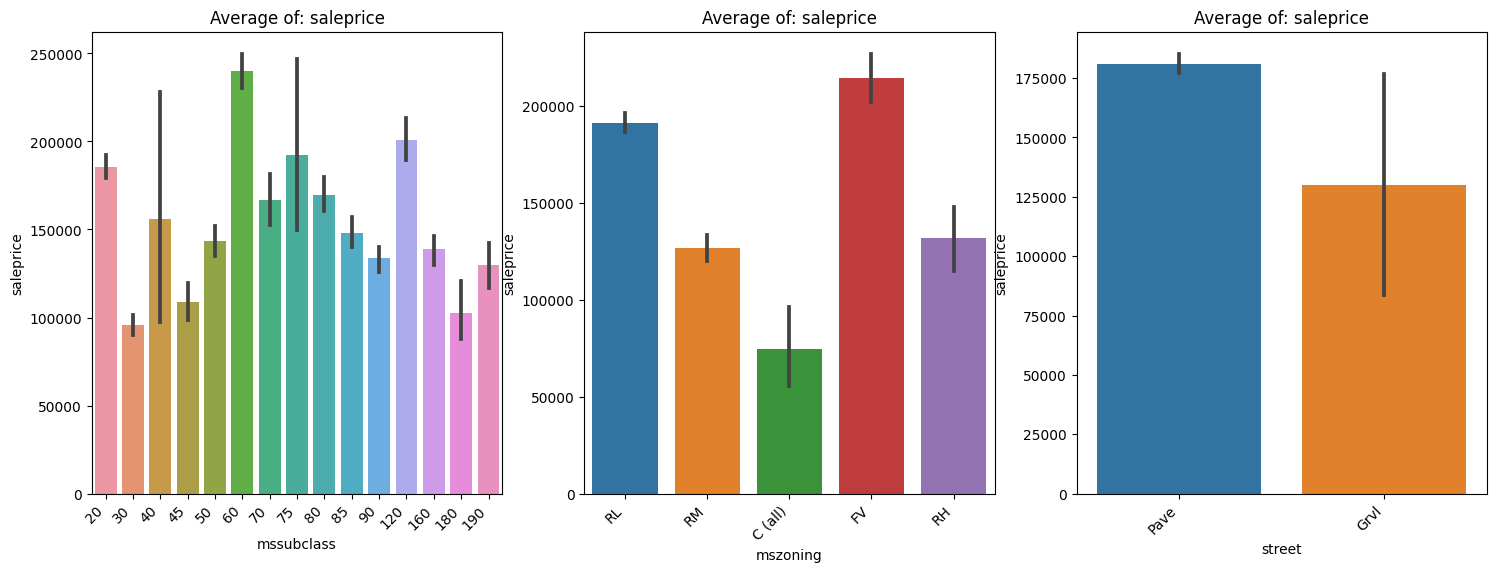

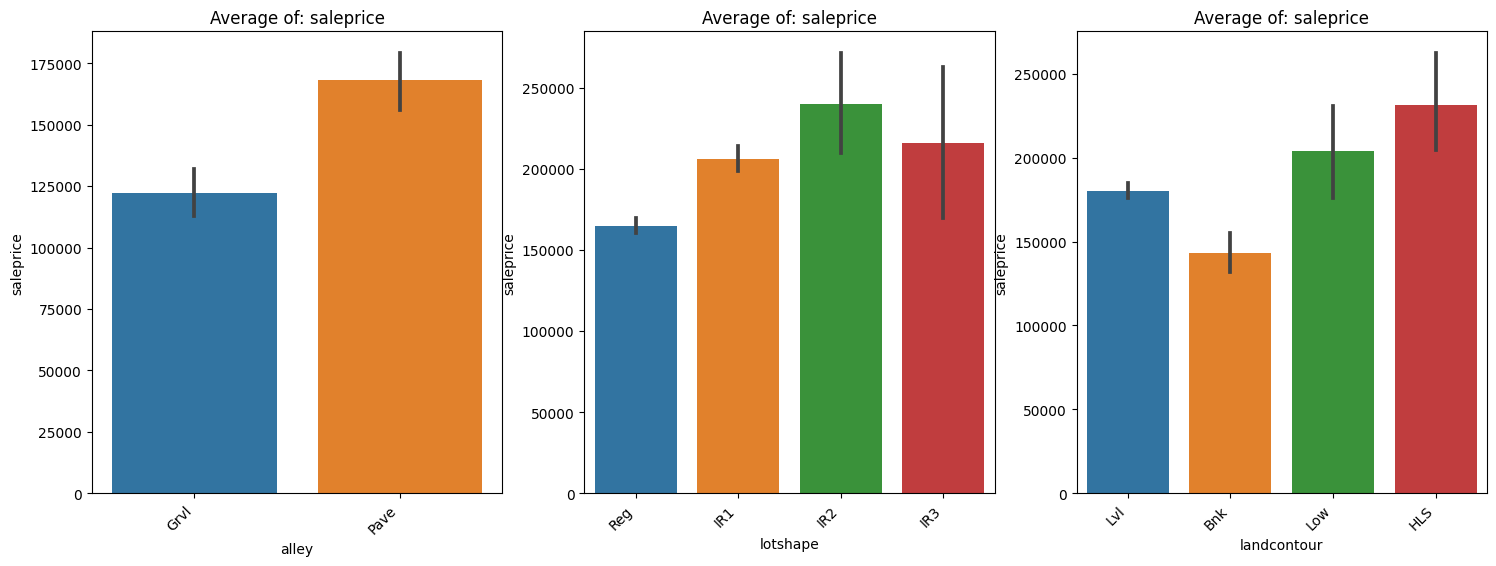

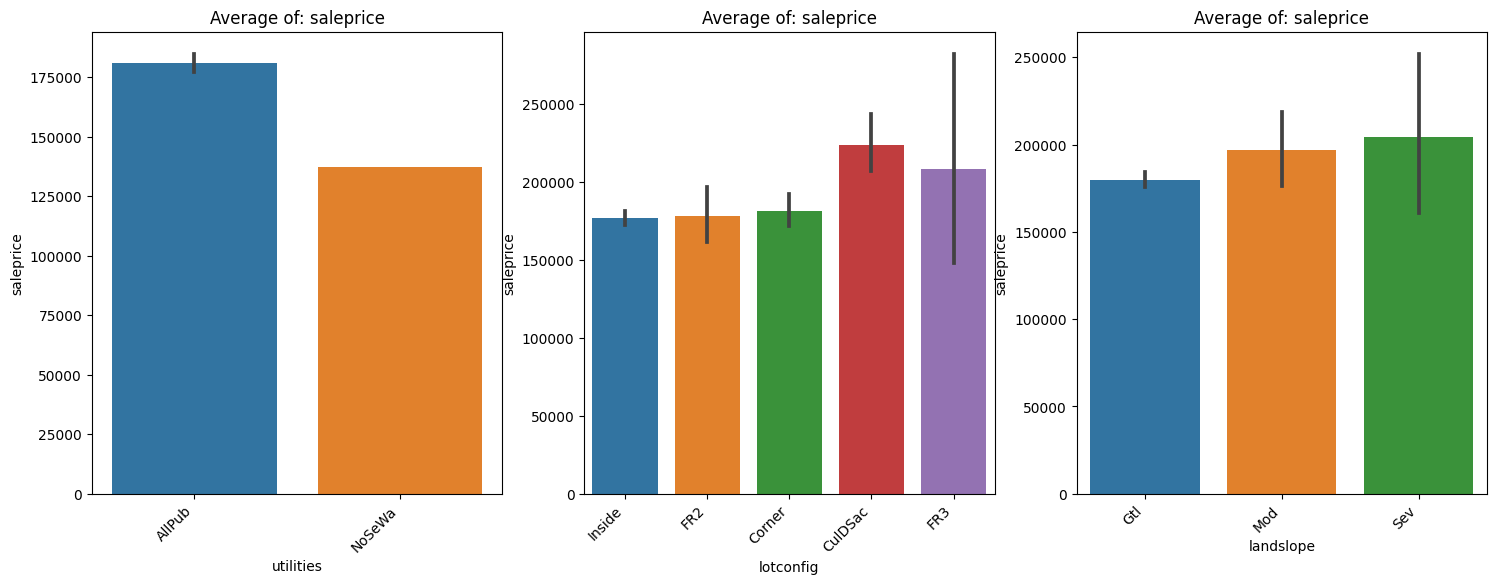

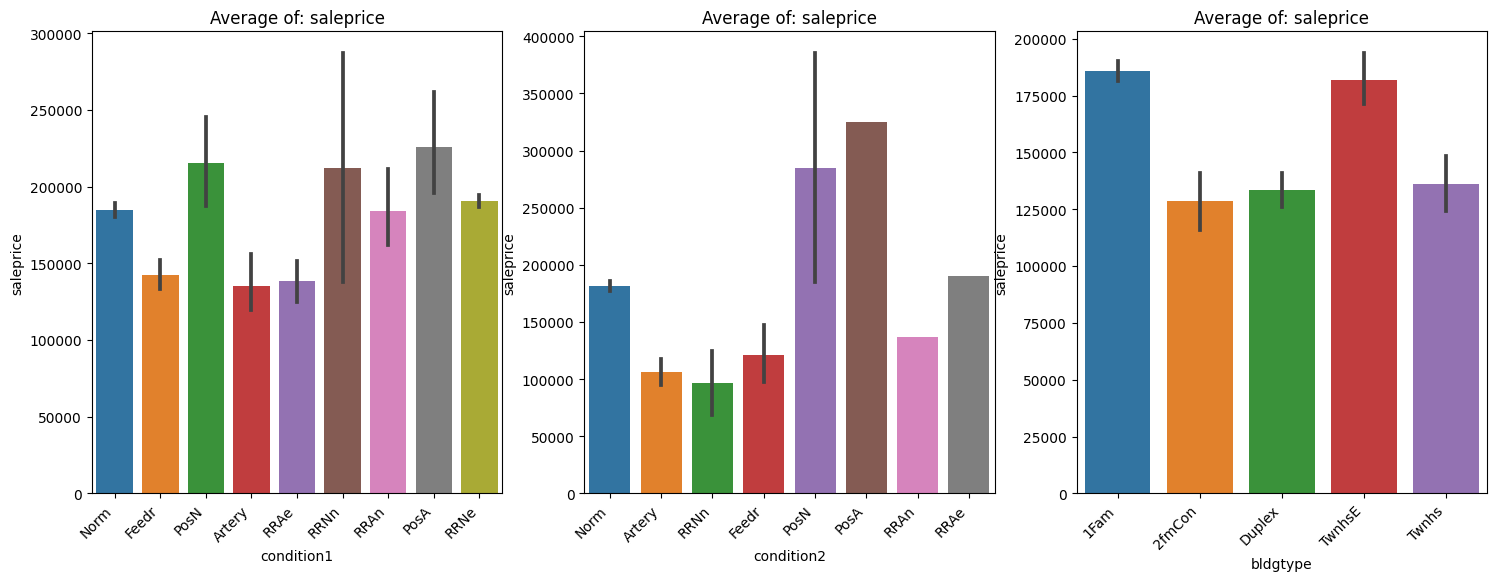

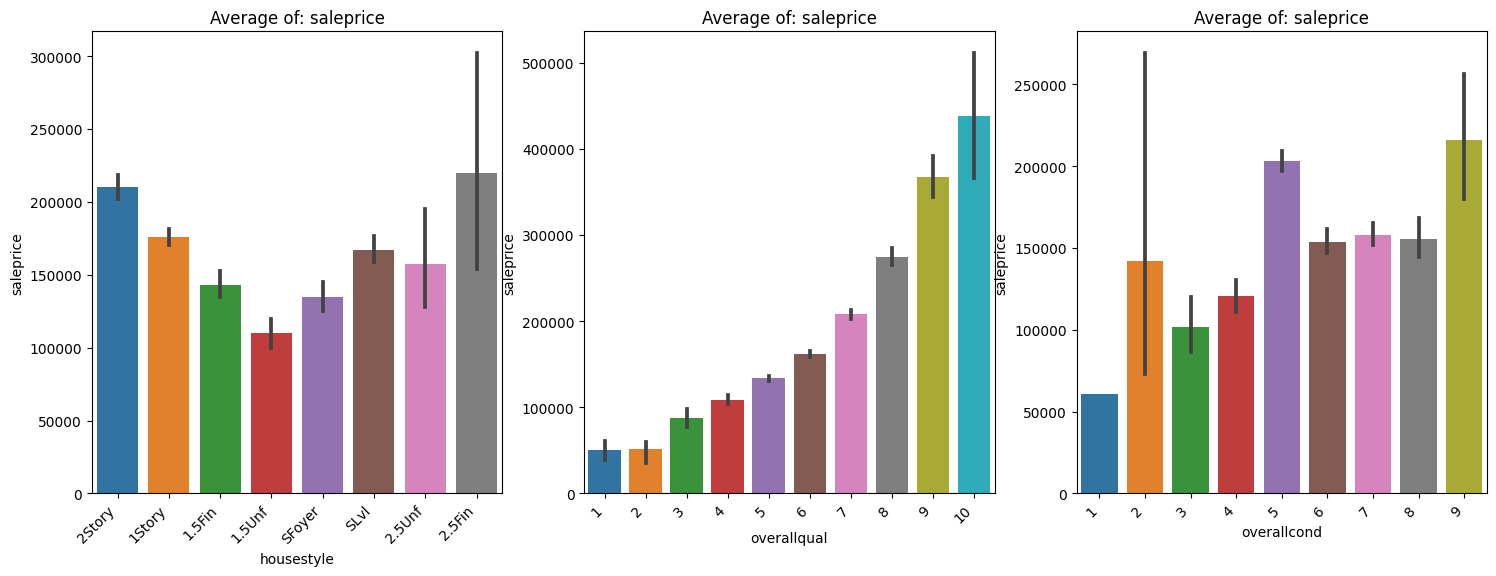

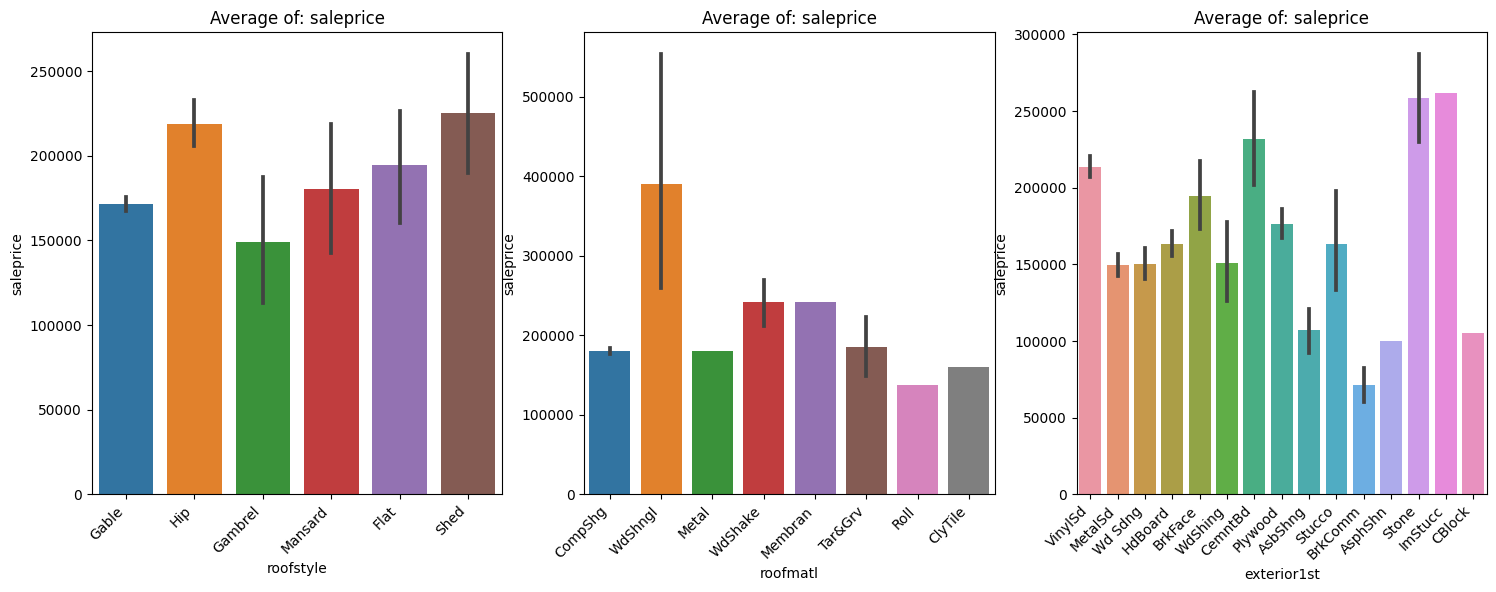

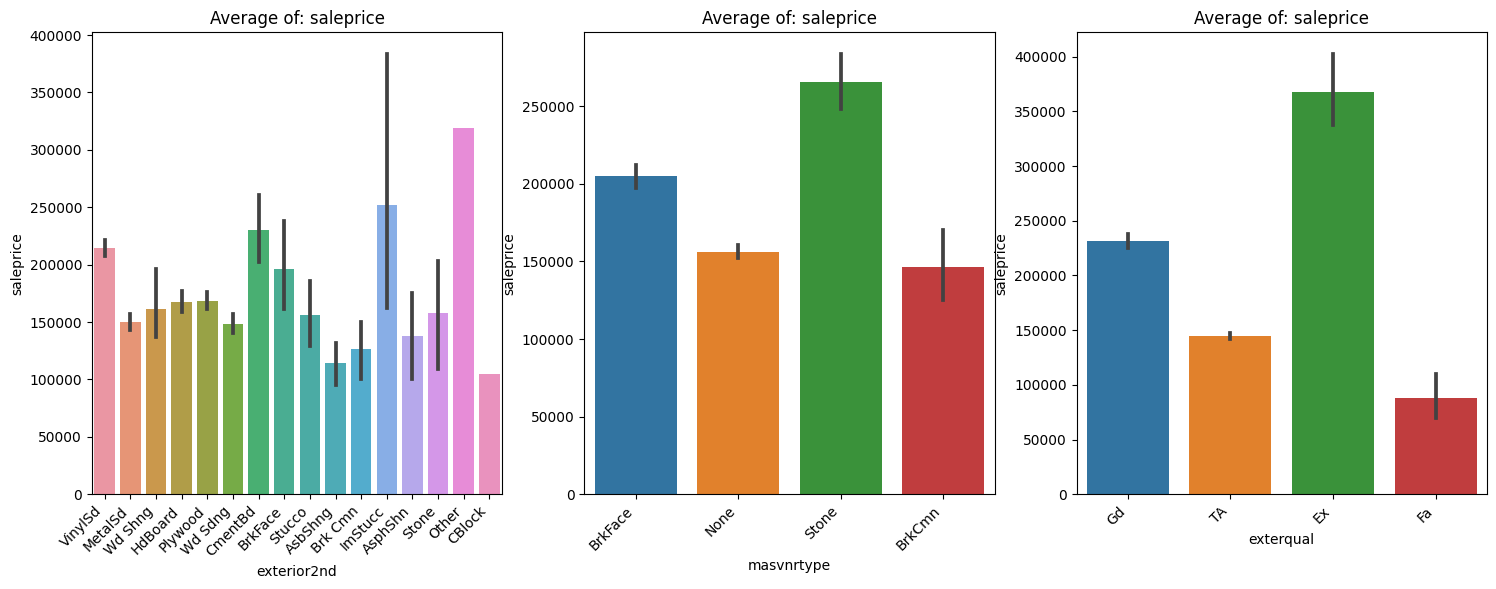

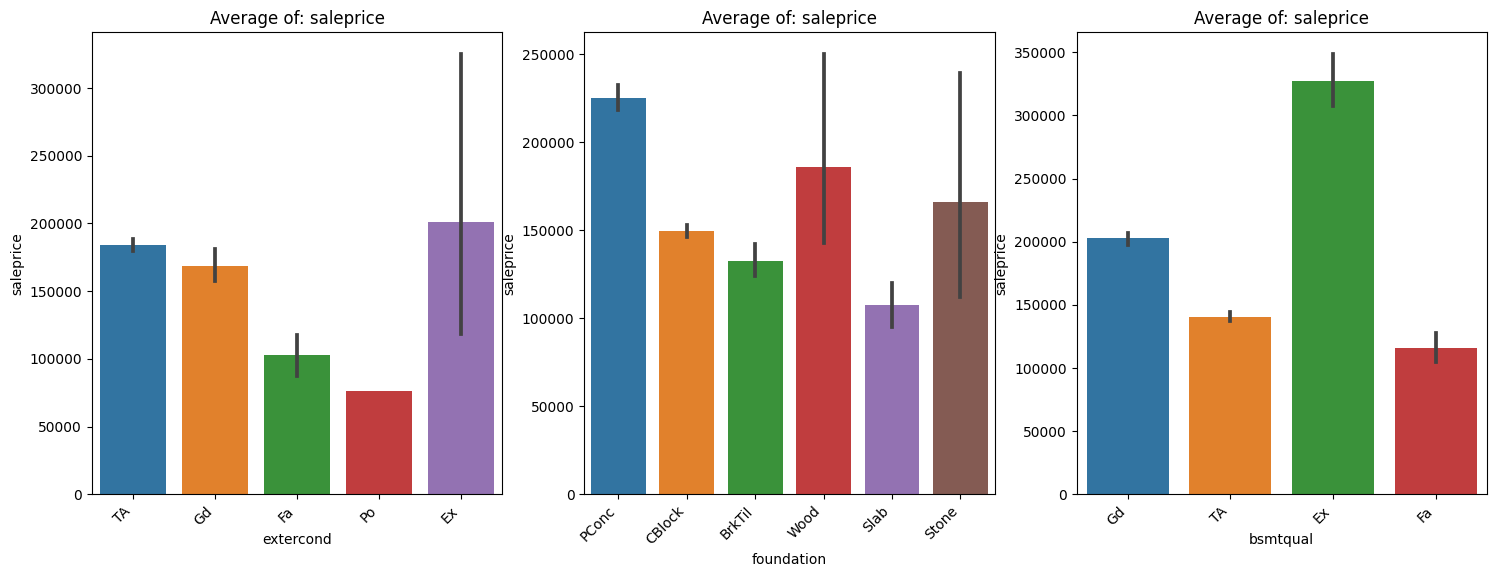

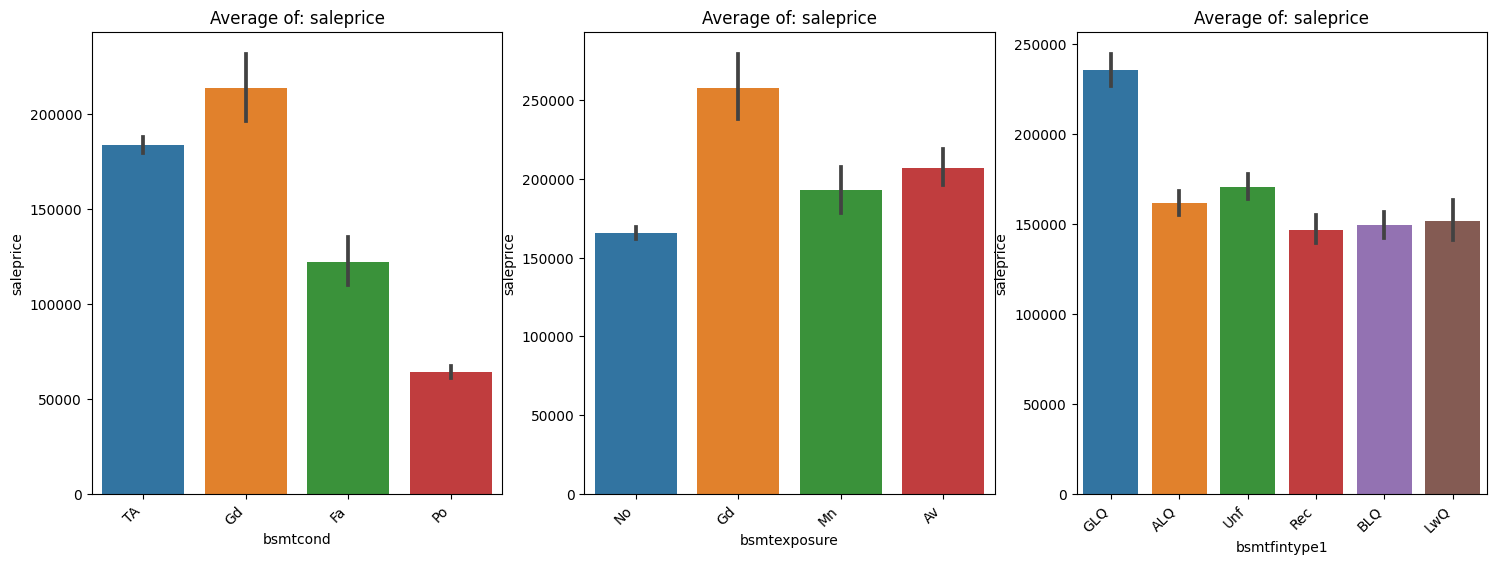

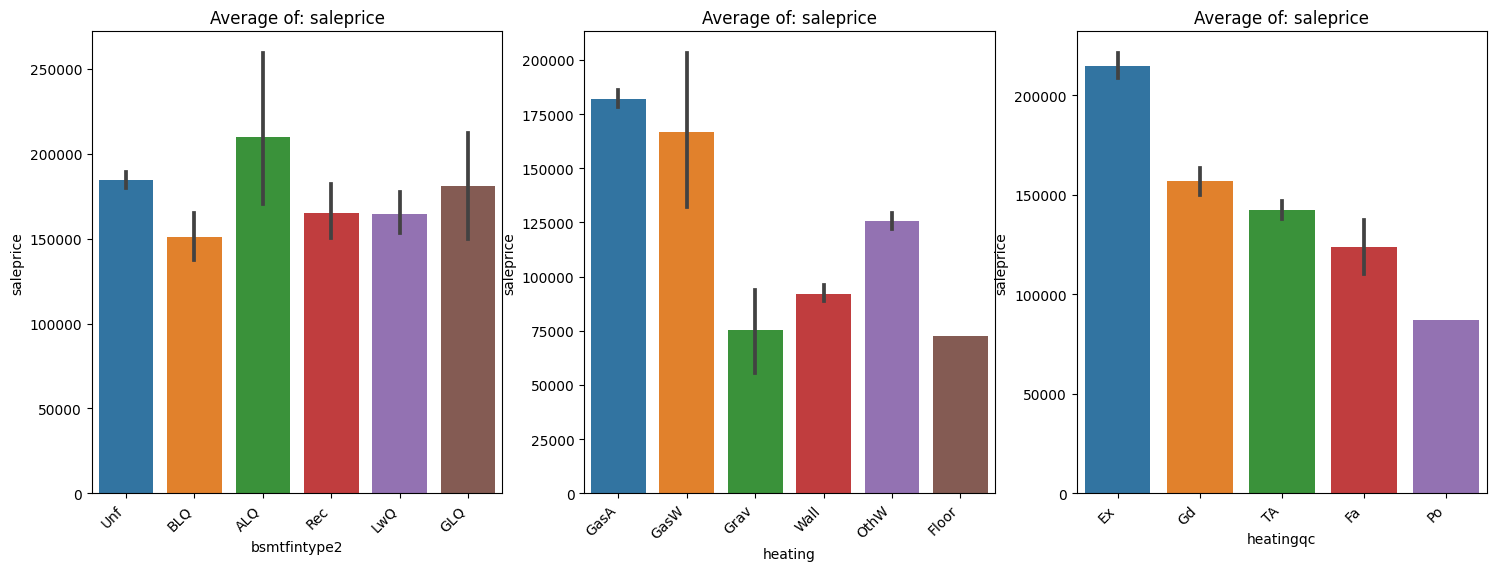

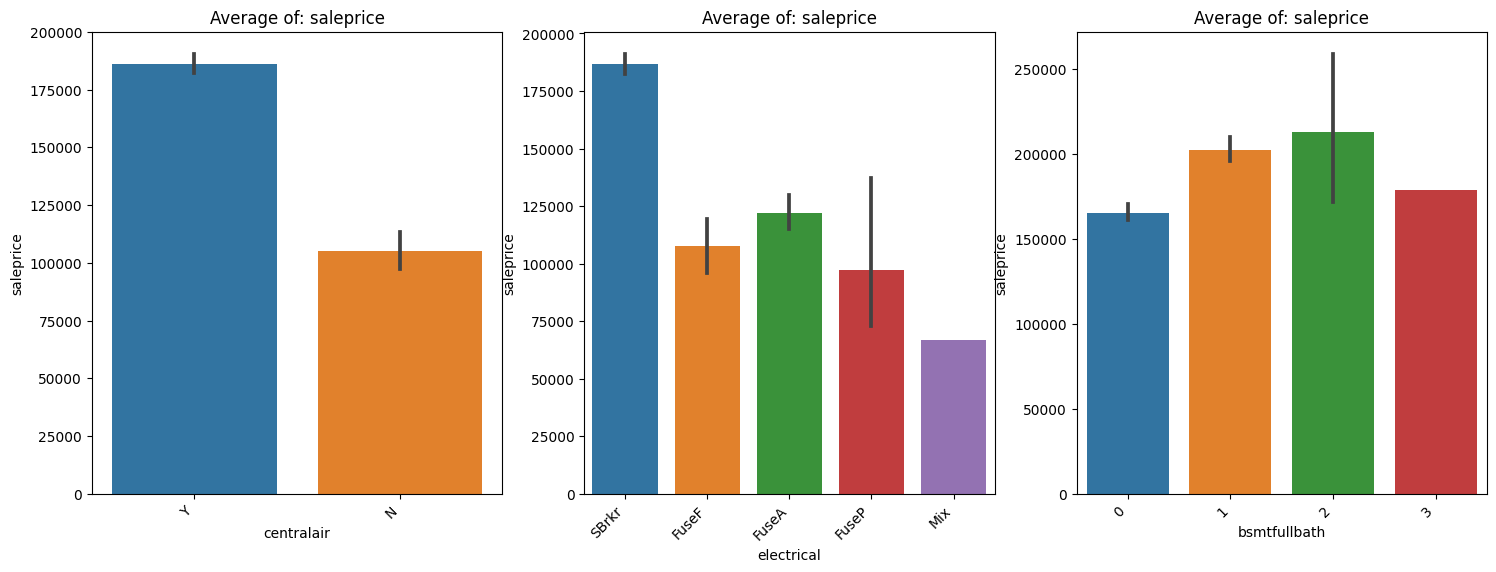

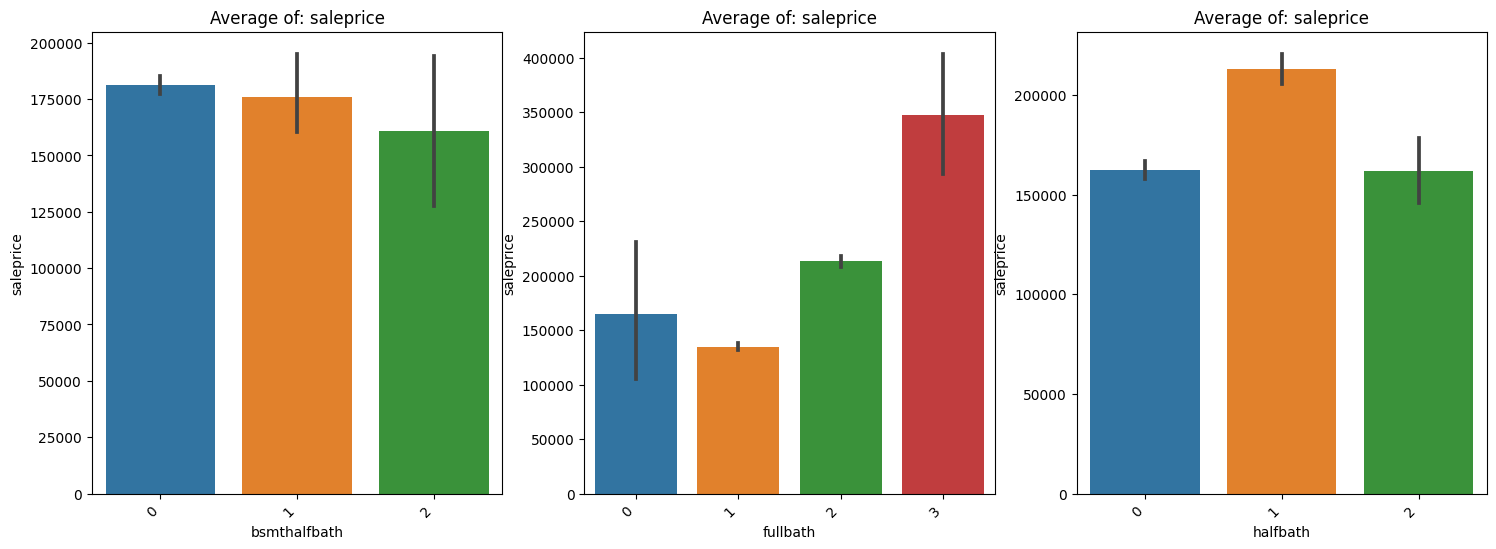

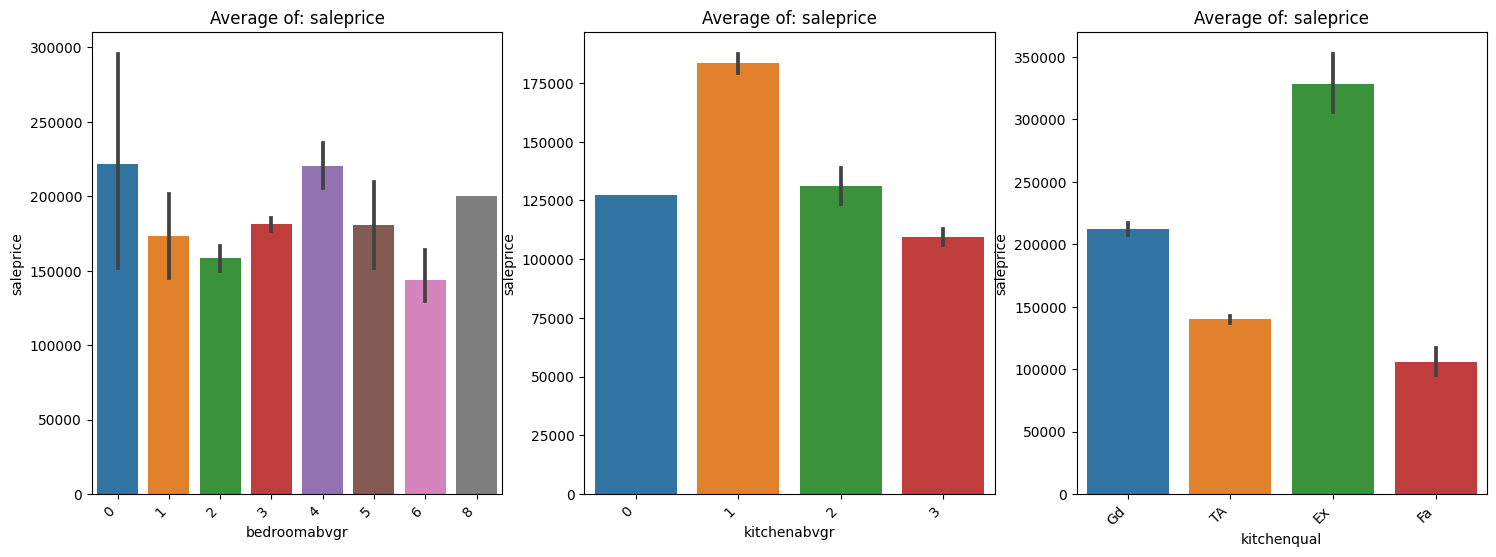

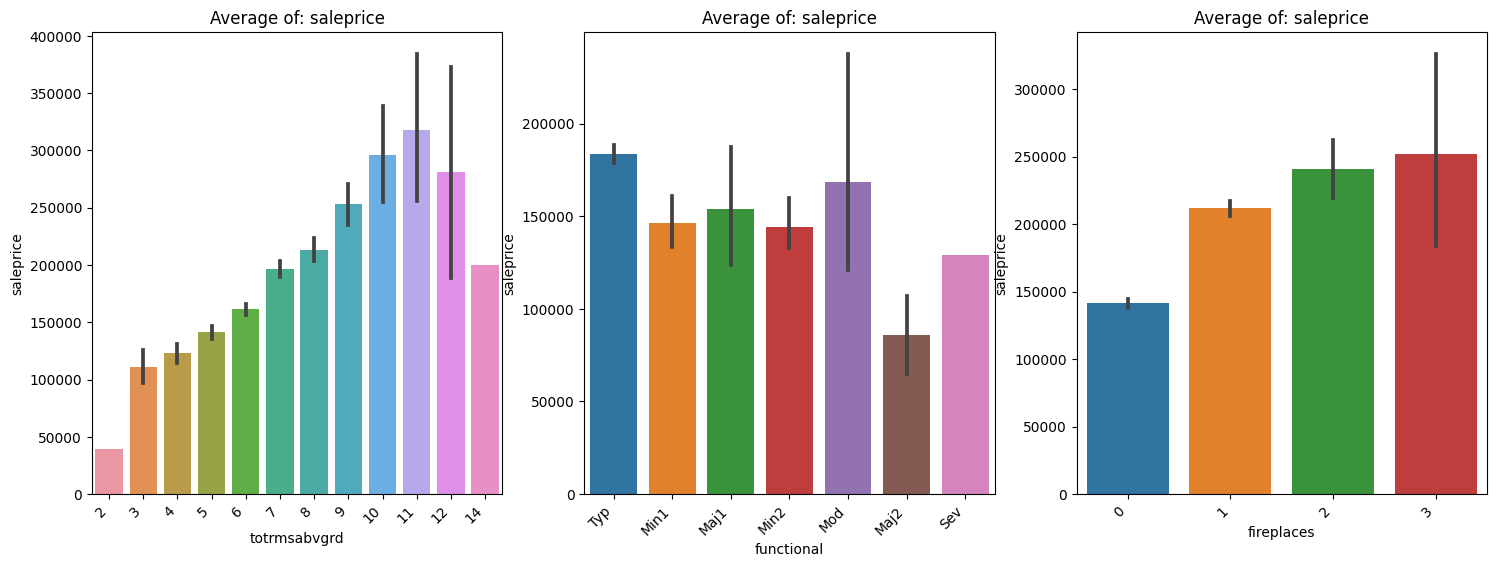

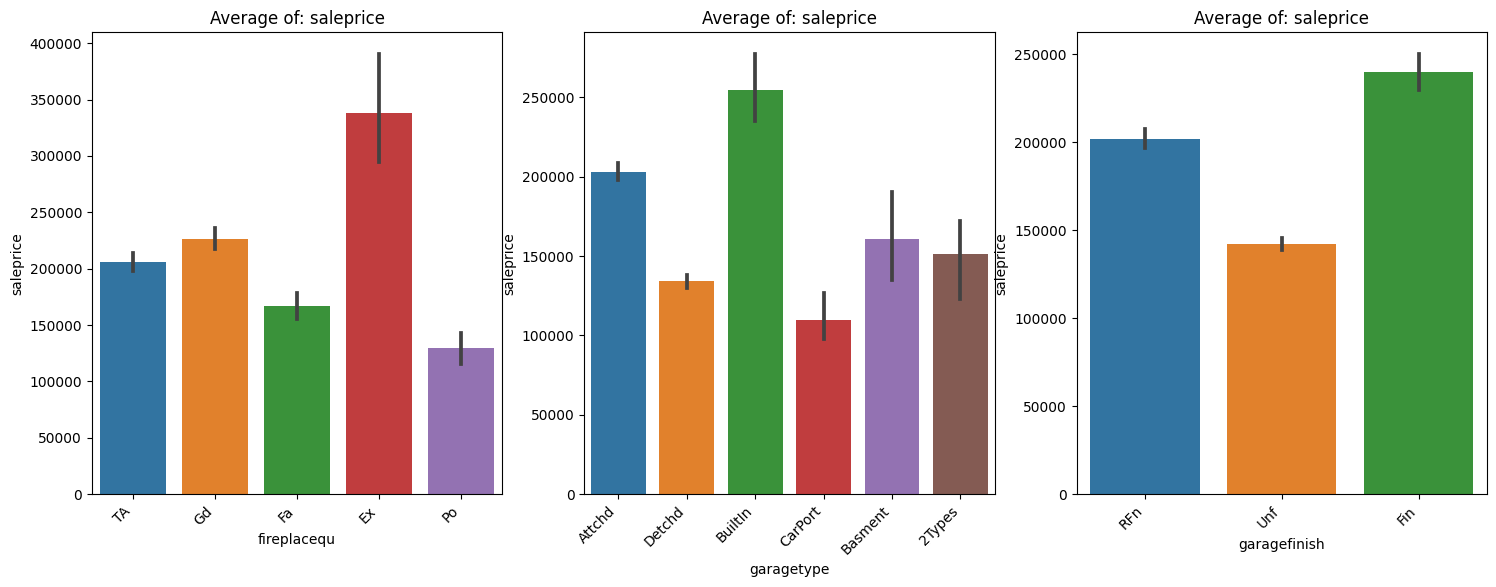

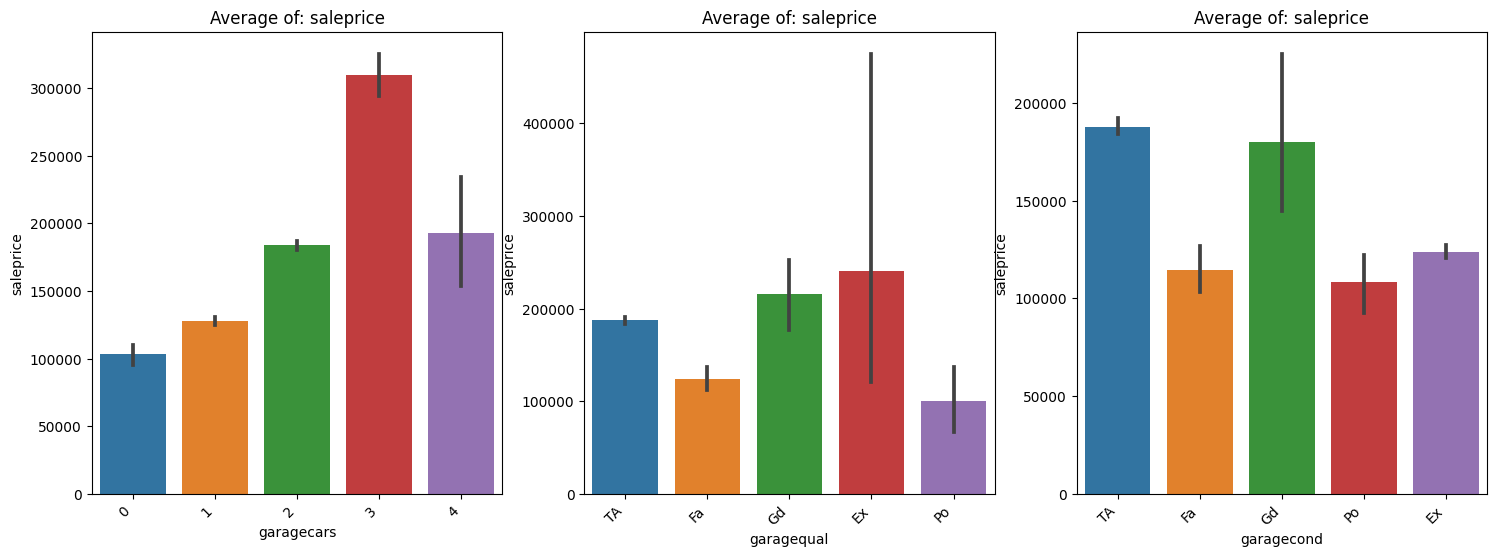

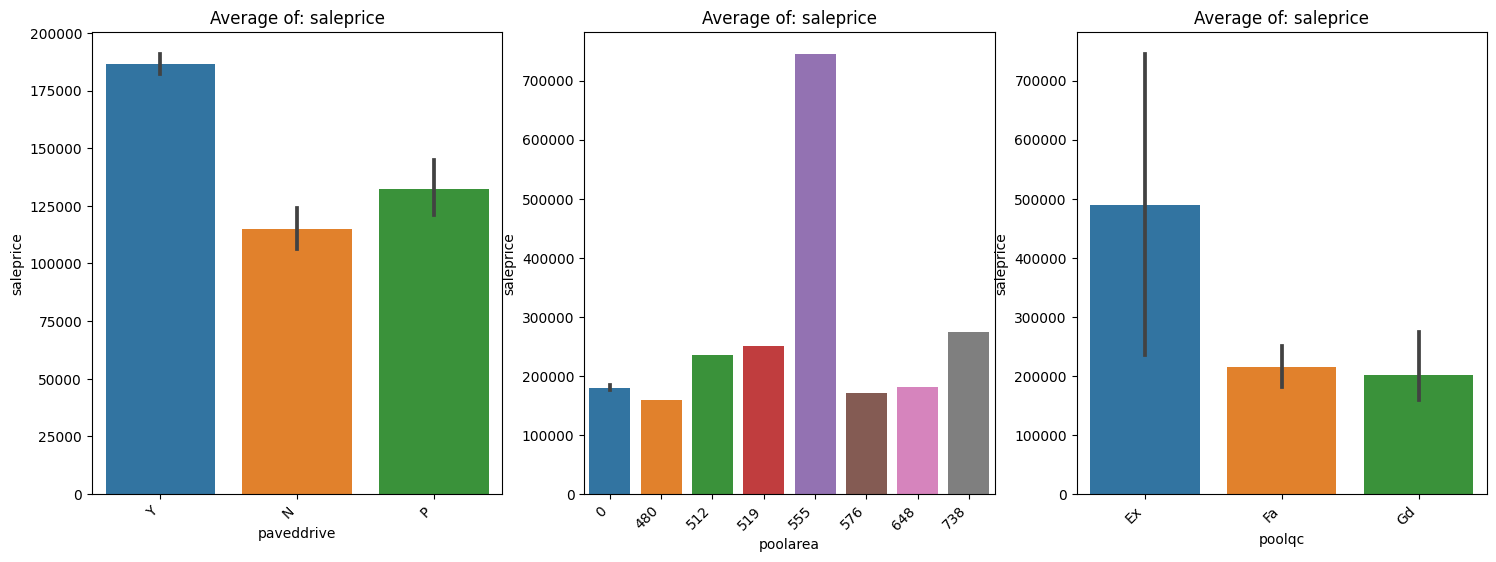

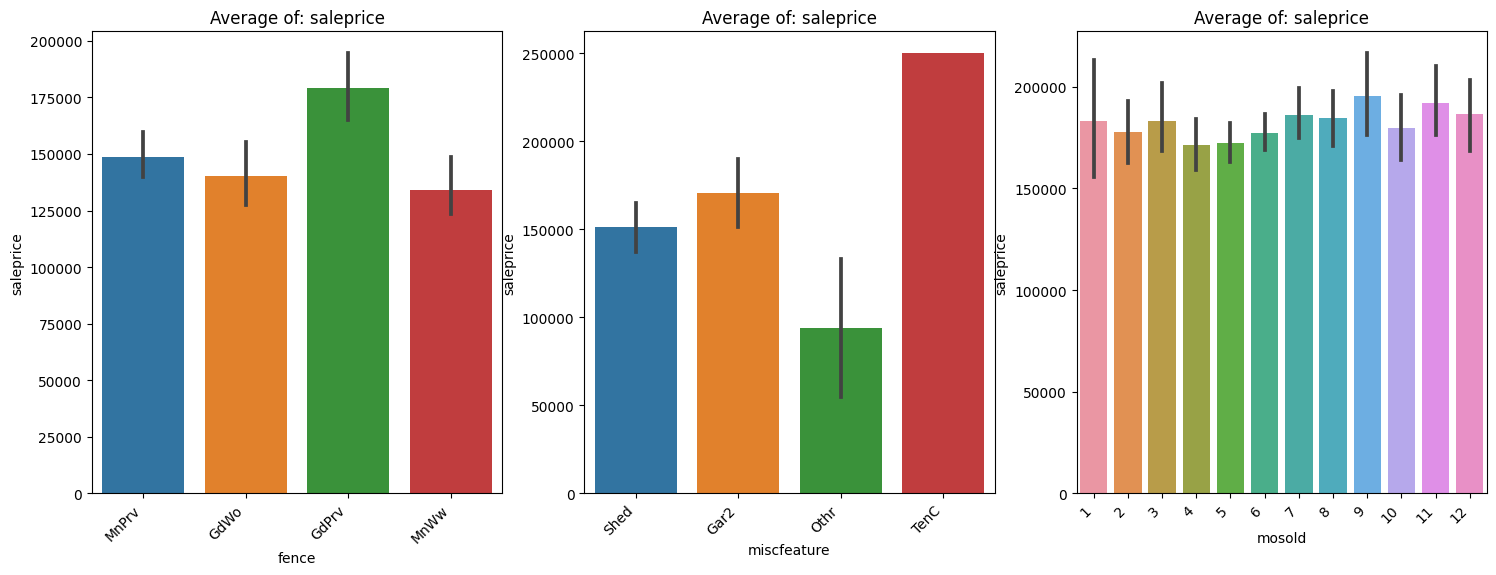

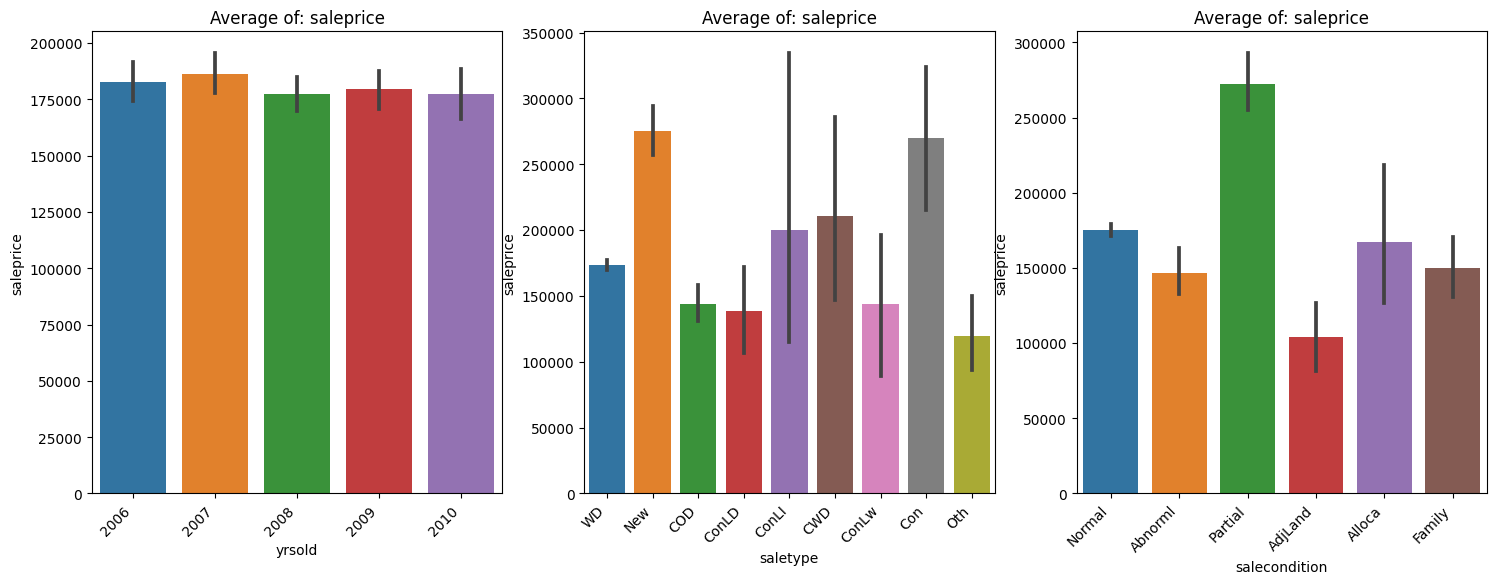

In [8]:
barplots(categorical, 'saleprice')

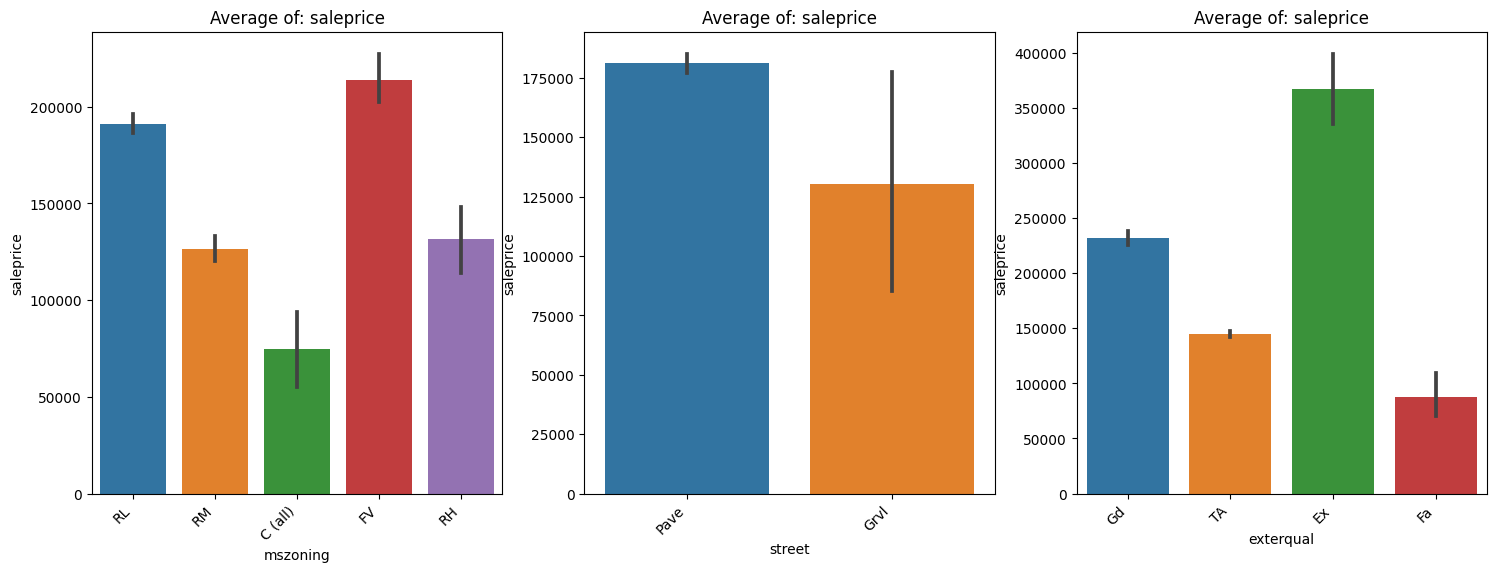

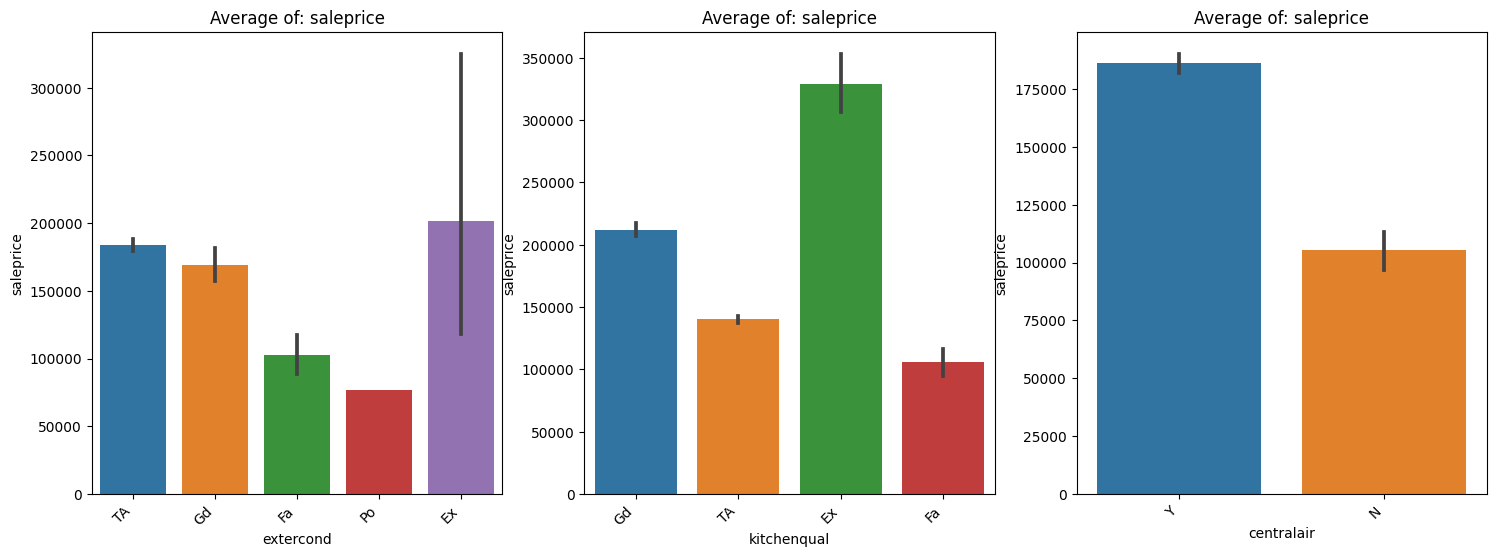

In [9]:
selectedvars = ['mszoning', 'street', 'exterqual', 'extercond', 'kitchenqual', 'centralair']
barplots(selectedvars, 'saleprice')

In [10]:
statdifference(selectedvars, 'saleprice')

*----------------------------------*
Comaprison of variables: saleprice and mszoning
*----------------------------------*
t-test between groups RL and RM: 
TtestResult(statistic=11.438976301048546, pvalue=5.31147433276907e-29, df=1367.0)
t-test between groups RL and C (all): 
TtestResult(statistic=4.5554032850378485, pvalue=5.781371468431197e-06, df=1159.0)
t-test between groups RL and FV: 
TtestResult(statistic=-2.2695213034922688, pvalue=0.023411437975482768, df=1214.0)
t-test between groups RL and RH: 
TtestResult(statistic=2.9391375423118626, pvalue=0.0033561549774499266, df=1165.0)
t-test between groups RM and C (all): 
TtestResult(statistic=3.334731251556495, pvalue=0.000997822737851211, df=226.0)
t-test between groups RM and FV: 
TtestResult(statistic=-12.555550172791989, pvalue=5.290552561341391e-29, df=281.0)
t-test between groups RM and RH: 
TtestResult(statistic=-0.42338400546928706, pvalue=0.6724073389418611, df=232.0)
t-test between groups C (all) and FV: 
TtestResult(stat

In [11]:
# Get dummies for non-numeric vars and add to dataframe

dummy_column_names = []

for varcat in selectedvars:

  dropFirst = False

  if len(houseprices_df[varcat].unique()) == 2:
    dropFirst = True

  houseprices_df = pd.concat([houseprices_df, pd.get_dummies(houseprices_df[varcat], prefix= varcat, drop_first=dropFirst)], axis= 1)
  dummy_column_names = dummy_column_names + list(pd.get_dummies(houseprices_df[varcat], prefix= varcat, drop_first=dropFirst).columns)

In [12]:
houseprices_df['mszoning'].unique()

array(['RL', 'RM', 'C (all)', 'FV', 'RH'], dtype=object)

In [13]:
dummy_column_names

['mszoning_C (all)',
 'mszoning_FV',
 'mszoning_RH',
 'mszoning_RL',
 'mszoning_RM',
 'street_Pave',
 'exterqual_Ex',
 'exterqual_Fa',
 'exterqual_Gd',
 'exterqual_TA',
 'extercond_Ex',
 'extercond_Fa',
 'extercond_Gd',
 'extercond_Po',
 'extercond_TA',
 'kitchenqual_Ex',
 'kitchenqual_Fa',
 'kitchenqual_Gd',
 'kitchenqual_TA',
 'centralair_Y']

Continuous

OverallQual

YearBuilt

grlivarea

garagecars

totalsf combo of totalbsmsf and firstflrsf

fullbath

Categorical

mszoning

street

exterqual

extercond

kitchenqual

centralair

All Nulls are in light green



<Axes: >

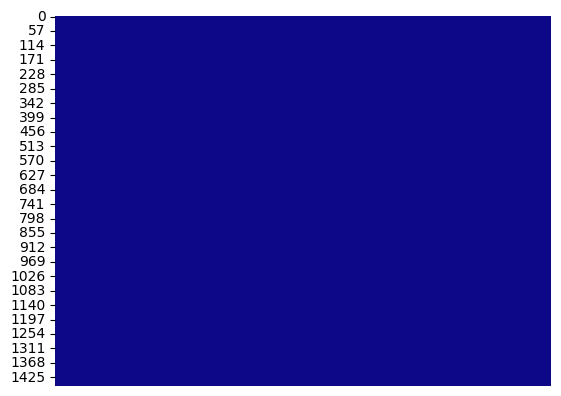

In [14]:
# Clean selected features

print('All Nulls are in light green\n')

sns.heatmap(houseprices_df[['overallqual', 'grlivarea', 'yearbuilt', 'garagecars', 'fullbath']].isnull(), xticklabels= False, cbar= False, cmap='plasma')

Deal with outliers for saleprice

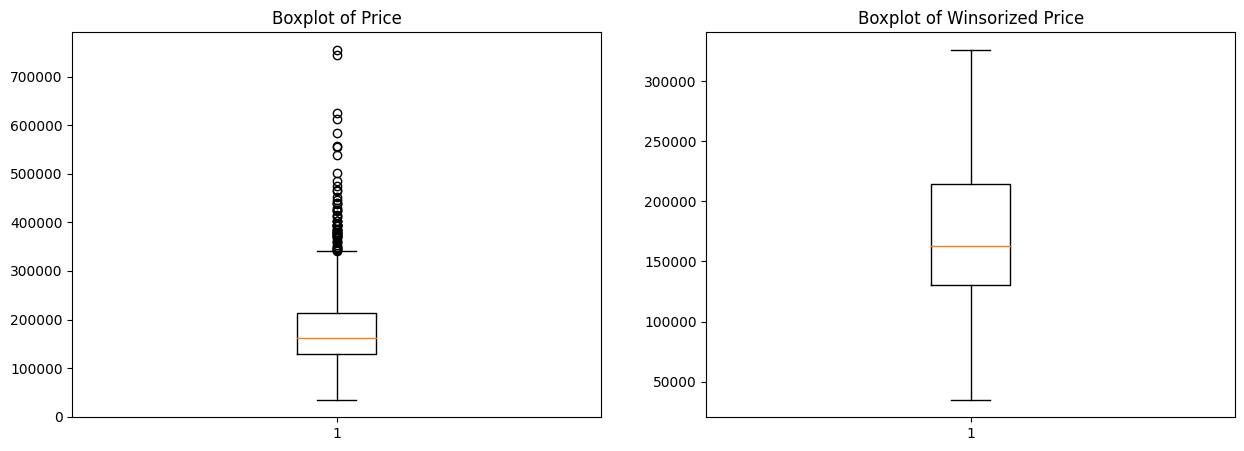

In [15]:
from scipy.stats.mstats import winsorize

winsorized_price = winsorize(houseprices_df['saleprice'], (0, 0.05))

plt.figure(figsize= (15, 5))

plt.subplot(1, 2, 1)
plt.boxplot(houseprices_df['saleprice'])
plt.title('Boxplot of Price')

plt.subplot(1, 2, 2)
plt.boxplot(winsorized_price)
plt.title("Boxplot of Winsorized Price")
plt.show()

Apply winsorized version of saleprice

In [16]:
houseprices_df['winsorized_saleprice'] = winsorized_price

Apply new total floors variable

In [17]:
houseprices_df['totalsf'] = houseprices_df['totalbsmtsf'] + houseprices_df['firstflrsf']

X = houseprices_df[['overallqual', 'grlivarea', 'yearbuilt', 'garagecars', 'totalsf', 'fullbath'] + dummy_column_names]

y = houseprices_df['winsorized_saleprice']

X = sm.add_constant(X)

### Spliting into training and testing sets where 20% test_size

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.20, random_state= 42)

### Building OLS, Lasso, Ridge, and Elastic models and use 5 cv to select best hyperparameters

In [19]:
lrm = LinearRegression()
lrm.fit(X_train, y_train)

# Predictions
y_preds_test = lrm.predict(X_test)
accuracy = cross_val_score(lrm, X_train, y_train, cv= 5)

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))
print("Accuracy: %0.3f (+/- %0.3f)" % (accuracy.mean(), accuracy.std() * 2))

R-squared of the model in the training set is: 0.8167623145471772
-----Test set statistics-----
R-squared of the model in the test set is: 0.8678375999937191
Mean absolute error of the prediction is: 18708.07834621219
Mean squared error of the prediction is: 594990503.1661217
Root mean squared error of the prediction is: 24392.427168408678
Mean absolute percentage error of the prediction is: 12.933442545427907
Accuracy: 0.798 (+/- 0.146)


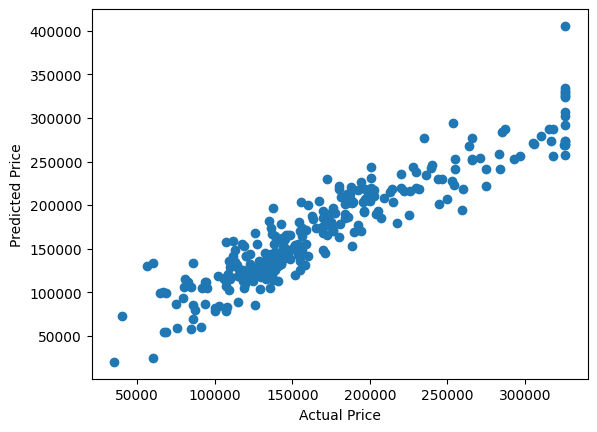

In [20]:
plt.scatter(y_test, y_preds_test)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.show()


In [21]:
# Ridge Regression

alphas = [np.power(10.0, p) for p in np.arange(-10, 40, 1)]

ridgeregr = RidgeCV(alphas= alphas)
ridgeregr.fit(X_train, y_train)

# Predictions
y_preds_test = ridgeregr.predict(X_test)

# K-fold
accuracy = cross_val_score(ridgeregr, X_train, y_train, cv= 5)

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))
print("Accuracy: %0.3f (+/- %0.3f)" % (accuracy.mean(), accuracy.std() * 2))

R-squared of the model in the training set is: 0.8167623145471772
-----Test set statistics-----
R-squared of the model in the test set is: 0.8678375999937191
Mean absolute error of the prediction is: 18627.11369594653
Mean squared error of the prediction is: 591031621.6137319
Root mean squared error of the prediction is: 24311.141923277315
Mean absolute percentage error of the prediction is: 12.851750393102776
Accuracy: 0.799 (+/- 0.145)


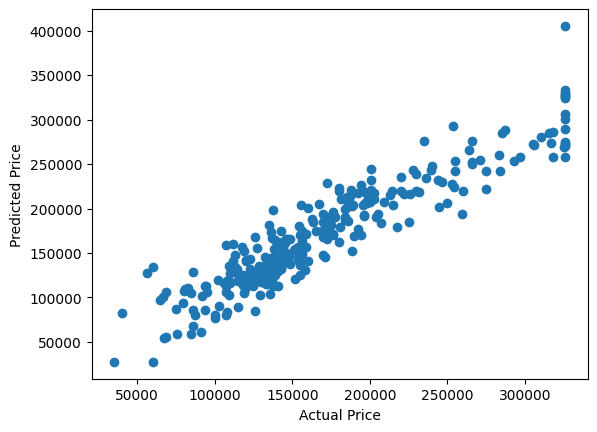

In [22]:
plt.scatter(y_test, y_preds_test)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.show()

In [23]:
# Lasso

lassoregr = LassoCV(alphas= alphas, cv = 5)
lassoregr.fit(X_train, y_train)

# Predictions
y_preds_test = lassoregr.predict(X_test)

# K-fold
accuracy = cross_val_score(lassoregr, X_train, y_train, cv= 5)

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))
print("Accuracy: %0.3f (+/- %0.3f)" % (accuracy.mean(), accuracy.std() * 2))

R-squared of the model in the training set is: 0.8167623145471772
-----Test set statistics-----
R-squared of the model in the test set is: 0.8678375999937191
Mean absolute error of the prediction is: 18789.209266502698
Mean squared error of the prediction is: 601980677.0183008
Root mean squared error of the prediction is: 24535.294516640733
Mean absolute percentage error of the prediction is: 13.018292971406872
Accuracy: 0.799 (+/- 0.145)


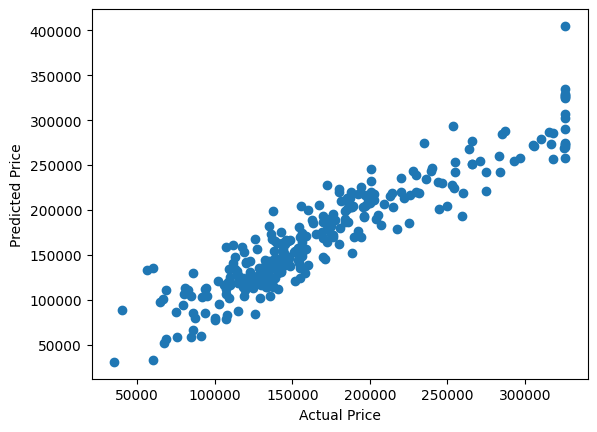

In [24]:
plt.scatter(y_test, y_preds_test)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.show()

In [25]:
# Elastic

elasticregr = ElasticNetCV(alphas= alphas, cv= 5)
elasticregr.fit(X_train, y_train)

# Predictions
y_preds_test = elasticregr.predict(X_test)

# K-fold
accuracy = cross_val_score(elasticregr, X_train, y_train, cv = 5)

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))
print("Accuracy: %0.3f (+/- %0.3f)" % (accuracy.mean(), accuracy.std() * 2))

R-squared of the model in the training set is: 0.8167623145471772
-----Test set statistics-----
R-squared of the model in the test set is: 0.8678375999937191
Mean absolute error of the prediction is: 18658.169721606213
Mean squared error of the prediction is: 592064641.1391995
Root mean squared error of the prediction is: 24332.378452161218
Mean absolute percentage error of the prediction is: 12.881200944869157
Accuracy: 0.799 (+/- 0.146)


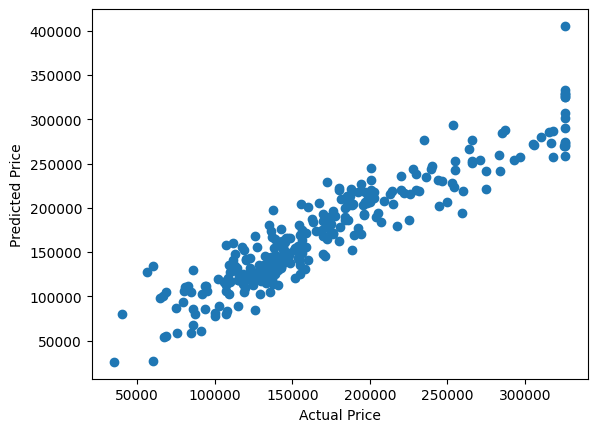

In [26]:
plt.scatter(y_test, y_preds_test)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.show()

After evaluating all the regression types I found that the Ridge Regression actually performs the best slightly compared to the other models.

In [27]:
houseprices_df['yrsold'].value_counts()

2009    338
2007    329
2006    314
2008    304
2010    175
Name: yrsold, dtype: int64

Using total construction spending by year data

Link: https://www.census.gov/construction/c30/historical_data.html


In [28]:
construction_spending = pd.read_csv('/content/total_construction_spend.csv')
construction_spending.head()

,yrsold,total_con_mil
0,2002,847874
1,2003,891497
2,2004,991356
3,2005,1116811
4,2006,1161282


In [31]:
houseprices2_df = pd.merge(houseprices_df, construction_spending)
houseprices2_df

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,extercond_Po,extercond_TA,kitchenqual_Ex,kitchenqual_Fa,kitchenqual_Gd,kitchenqual_TA,centralair_Y,winsorized_saleprice,totalsf,total_con_mil
0,1,60,RL,65.000,8450,Pave,None,Reg,Lvl,AllPub,...,0,1,0,0,1,0,1,208500,1712,1077350
1,3,60,RL,68.000,11250,Pave,None,IR1,Lvl,AllPub,...,0,1,0,0,1,0,1,223500,1840,1077350
2,5,60,RL,84.000,14260,Pave,None,IR1,Lvl,AllPub,...,0,1,0,0,1,0,1,250000,2290,1077350
3,9,50,RM,51.000,6120,Pave,None,Reg,Lvl,AllPub,...,0,1,0,0,0,1,1,129900,1974,1077350
4,10,190,RL,50.000,7420,Pave,None,Reg,Lvl,AllPub,...,0,1,0,0,0,1,1,118000,2068,1077350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1439,20,RM,90.000,7407,Pave,None,Reg,Lvl,AllPub,...,0,1,0,0,0,1,1,149700,2148,812964
1456,1447,20,RL,NaN,26142,Pave,None,IR1,Lvl,AllPub,...,0,1,0,0,0,1,1,157900,2376,812964
1457,1457,20,RL,85.000,13175,Pave,None,Reg,Lvl,AllPub,...,0,1,0,0,0,1,1,210000,3615,812964
1458,1458,70,RL,66.000,9042,Pave,None,Reg,Lvl,AllPub,...,0,0,0,0,1,0,1,266500,2340,812964


In [32]:
houseprices2_df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,extercond_Po,extercond_TA,kitchenqual_Ex,kitchenqual_Fa,kitchenqual_Gd,kitchenqual_TA,centralair_Y,winsorized_saleprice,totalsf,total_con_mil
0,1,60,RL,65.000,8450,Pave,None,Reg,Lvl,AllPub,...,0,1,0,0,1,0,1,208500,1712,1077350
1,3,60,RL,68.000,11250,Pave,None,IR1,Lvl,AllPub,...,0,1,0,0,1,0,1,223500,1840,1077350
2,5,60,RL,84.000,14260,Pave,None,IR1,Lvl,AllPub,...,0,1,0,0,1,0,1,250000,2290,1077350
3,9,50,RM,51.000,6120,Pave,None,Reg,Lvl,AllPub,...,0,1,0,0,0,1,1,129900,1974,1077350
4,10,190,RL,50.000,7420,Pave,None,Reg,Lvl,AllPub,...,0,1,0,0,0,1,1,118000,2068,1077350


In [33]:
X = houseprices2_df[['overallqual', 'grlivarea', 'yearbuilt', 'garagecars', 'totalsf', 'fullbath', 'total_con_mil'] + dummy_column_names]

y = houseprices2_df['winsorized_saleprice']

X = sm.add_constant(X)

In [34]:
lrm = LinearRegression()
lrm.fit(X_train, y_train)

y_preds_test = lrm.predict(X_test)
accuracy = cross_val_score(lrm, X_train , y_train, cv= 5)

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))
print("Accuracy: %0.3f (+/- %0.3f)" % (accuracy.mean(), accuracy.std() * 2))

R-squared of the model in the training set is: 0.8167623145471772
-----Test set statistics-----
R-squared of the model in the test set is: 0.8678375999937191
Mean absolute error of the prediction is: 18708.07834621219
Mean squared error of the prediction is: 594990503.1661217
Root mean squared error of the prediction is: 24392.427168408678
Mean absolute percentage error of the prediction is: 12.933442545427907
Accuracy: 0.798 (+/- 0.146)


No significant improvements to the model